In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
%matplotlib inline
import matplotlib.pyplot as plt
from knn_regression import KNN 
from nwk import NWK
from sklearn.cross_validation import train_test_split

In [2]:
df0 = pd.read_csv("data.csv")

In [3]:
df0.columns

Index([u'latitude', u'longitude', u'close_date', u'close_price'], dtype='object')

In [4]:
df0.describe()

,latitude,longitude,close_price
count,88042.000000,88042.000000,8.804200e+04
mean,34.559745,-93.470194,2.663684e+06
std,13.983900,31.194818,1.543381e+07
min,-89.938989,-179.891580,-9.995300e+04
25%,36.200312,-98.481499,1.233064e+05
50%,36.385215,-98.165490,1.816143e+05
75%,36.544719,-97.967260,2.841568e+05
max,89.984841,179.969440,1.009998e+08


In [10]:
df0.close_price = df0.close_price.apply(lambda x: abs(x))

In [30]:
df = df0.sample(5000)

In [6]:
df.dtypes

latitude       float64
longitude      float64
close_date      object
close_price    float64
dtype: object

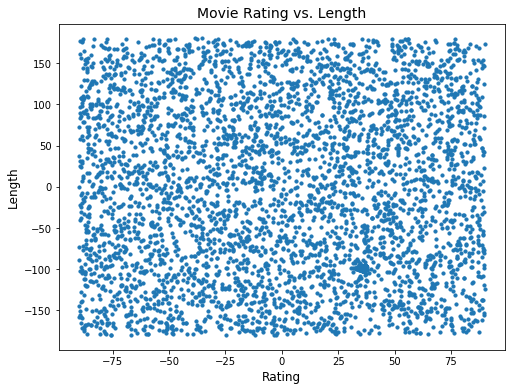

In [7]:
fig, ax = plt.subplots()
df0[['latitude','longitude']].plot(ax=ax, kind='scatter', x='latitude', y='longitude', s = 10,figsize=(8,6))
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Length', fontsize=12)
plt.title('Movie Rating vs. Length', fontsize=14)

In [33]:
# create design matrix X and target vector y
X = np.array(df0.ix[:, 0:3]) 
y = np.array(df0['close_price']) 

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print len(X_test)

29054


### Performance of model measured in Median Relative Absolute Error

In [ ]:
knn = KNN(4)
t0 = datetime.now()
knn.fit(X_train, y_train)
p = knn.predict(X_test)
print knn.mrae(X_test,y_test)
print ("Training time:", (datetime.now() - t0))

D:\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
D:\Anaconda2\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Determine the optimal k

In [14]:
k_list = []
mrae_list = []
for k in (1,2,3,4,5,6,7):
    knn = KNN(k)
    knn.fit(X_train, y_train)
    p = knn.predict(X_test)
    k_list.append(k)
    mrae_list.append(knn.mrae(X_test,y_test))

In [15]:
knn = KNN(k_list[mrae_list.index(min(mrae_list))])
t0 = datetime.now()
knn.fit(X_train, y_train)
print knn.mrae(X_test,y_test)
print ("Training time:", (datetime.now() - t0))

0.439755839824
('Training time:', datetime.timedelta(0, 1, 189000))


### Trends in error

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


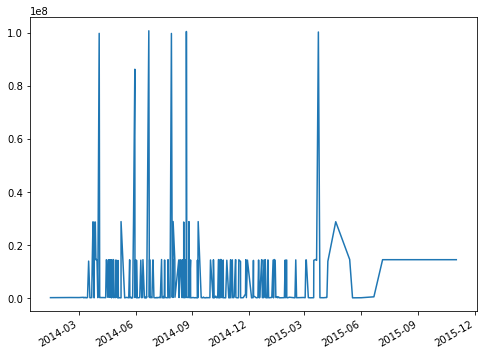

In [16]:
err = abs(y_test - p)
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = ['lat','long','datetime']
X_test_df['error'] = err
X_test_df['date'] = X_test_df.datetime.apply(lambda x: x[:10])
X_test_df['time'] = X_test_df.datetime.apply(lambda x: x[11:19])
X_test_df['datetime'] = X_test_df.datetime.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
X_test_df = X_test_df.sort('datetime')

fig, ax = plt.subplots(1,figsize=(8,6))
ax.plot(X_test_df.datetime, X_test_df.error )
fig.autofmt_xdate()

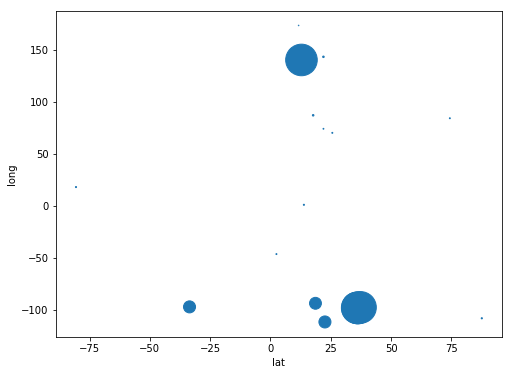

In [19]:
# size = [(i-min(X_test_df.error))/float(max(X_test_df.error)) for i in X_test_df.error]
fig, ax = plt.subplots()
X_test_df.plot(ax=ax, kind='scatter', x='lat', y='long', s = X_test_df.error/100000 ,figsize=(8,6))
# plt.xlabel('Rating', fontsize=12)
# plt.ylabel('Length', fontsize=12)
# plt.title('Movie Rating vs. Length', fontsize=14)

In [24]:
X_test_df[X_test_df.error > 80000000]

,lat,long,datetime,error,date,time
195,36.3996,-98.4031,2014-04-03 04:05:25.471480,9.973306e+07,2014-04-03,04:05:25
37,36.5585,-98.7352,2014-05-30 18:48:04.310954,8.620403e+07,2014-05-30,18:48:04
252,36.0671,-98.2238,2014-06-22 09:48:53.352111,1.007006e+08,2014-06-22,09:48:53
196,12.843,140.071,2014-07-28 22:31:17.770179,9.969998e+07,2014-07-28,22:31:17
40,35.9672,-98.2688,2014-08-22 03:45:00.745437,1.004384e+08,2014-08-22,03:45:00
169,37.3075,-97.8227,2015-03-23 12:41:22.903670,1.002474e+08,2015-03-23,12:41:22


### Improvement in model

In [20]:
print len(X_test)
nwk = NWK(0.01)
t0 = datetime.now()
nwk.fit(X_train, y_train)
print nwk.mrae(X_test,y_test)
print ("Training time:", (datetime.now() - t0))

330


nwk.py:71: RuntimeWarning: invalid value encountered in double_scalars
  sum_y += kernel[ll] / float(sum(kernel)) * self.y_train[distances[ll][1]]


19 Nan values have been predicted
6.41091467435
('Training time:', datetime.timedelta(0, 16, 29000))


In [21]:
# determine the optimal h
h_list = []
mrae_list = []
for h in np.linspace(start=0.001, stop=0.02, num=10):
    nwk = NWK(h)
    nwk.fit(X_train, y_train)
#     p = knn.predict(X_test)
    h_list.append(h)
    mrae_list.append(nwk.mrae(X_test,y_test))

39 Nan values have been predicted
26 Nan values have been predicted
22 Nan values have been predicted
20 Nan values have been predicted
19 Nan values have been predicted
18 Nan values have been predicted
18 Nan values have been predicted
18 Nan values have been predicted
17 Nan values have been predicted
17 Nan values have been predicted


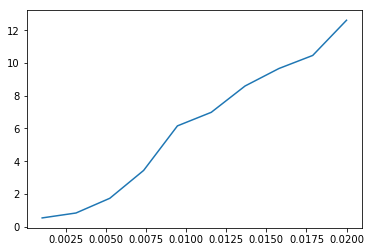

In [22]:
plt.plot(h_list, mrae_list)

In [23]:
print len(X_test)
nwk = NWK(h_list[mrae_list.index(min(mrae_list))])
t0 = datetime.now()
nwk.fit(X_train, y_train)
print nwk.mrae(X_test,y_test)
print ("Training time:", (datetime.now() - t0))

330
39 Nan values have been predicted
0.531441175436
('Training time:', datetime.timedelta(0, 15, 392000))


### Productionize in model